<h1>Building a Sequential Multi-Label Categorization CNN Model:</h1>

In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential # type: ignore
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, GlobalAveragePooling1D, Input # type: ignore
import tensorflow as tf

In [ ]:
# Importing user-defined module
from Scripts.ptbxl_ml import *

<h3>Checking For Available GPUs:</h3>

In [41]:
gpus = tf.config.list_physical_devices('GPU')

In [42]:
if gpus:
    for gpu in gpus:
        print(f'GPU Name: {gpu.name}')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs, ', len(logical_gpus), 'Logical GPUs')

else:
    print('No GPUs found')

No GPUs found


<h3>Loading PTB-XL Database from ".npz" File:</h3>

In [ ]:
npz_file = r'C:\Users\loera\OneDrive\Python Projects\College\ECG\Processed Datasets\ML_dataset.npz'

In [44]:
ptbxl_df, signals_df = load_database(npz_file)

<h3>Splitting Data into Training and Testing Sets:</h3>

In [45]:
# Formatting the signals and superclassses to numpy arrays
signals = signals_df.to_numpy(dtype=float)
superclasses = ptbxl_df.loc[:,'superclasses'].to_numpy(dtype=list)

In [ ]:
# Assigns data (signals) to X
X = signals

# Assigns labels (superclasses) to Y
Y = superclasses

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [48]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17110, 400) (17110,)
(4278, 400) (4278,)


<h3>Counting Instances of each Superclass:</h3>

In [49]:
from collections import Counter

str_y_train = [str(x) for x in y_train]

counter = Counter(str_y_train)

for label, num in counter.items():
    print(f'{label}: {num}')

['CD', 'HYP', 'STTC']: 160
['CD', 'STTC']: 376
['STTC']: 1904
['CD', 'NORM']: 331
['MI', 'STTC']: 473
['CD']: 1360
['NORM']: 7281
['MI']: 2044
['CD', 'MI', 'STTC']: 173
['HYP']: 418
['CD', 'MI']: 1032
['HYP', 'MI', 'STTC']: 289
['HYP', 'STTC']: 628
['CD', 'HYP', 'MI', 'STTC']: 131
['HYP', 'MI']: 146
['NORM', 'STTC']: 24
['CD', 'HYP', 'MI']: 94
['CD', 'HYP']: 236
['CD', 'NORM', 'STTC']: 5
['HYP', 'NORM']: 2
['CD', 'HYP', 'NORM']: 2
['CD', 'HYP', 'MI', 'NORM']: 1


<h3>Converting Labels/Superclasses into Binary Matrix Format:</h3>

In [50]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

In [62]:
# Showing original versus encoded labels
print('Classes:', mlb.classes_)

print('\nEncoded Training Labels:\n', y_train[:5])
print('\nOriginal Training Labels:\n', mlb.inverse_transform(y_train[:5]))

print('\nEncoded Testing Labels:\n', y_test[:5])
print('\nOriginal Testing Labels:\n', mlb.inverse_transform(y_test[:5]))

Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']

Encoded Training Labels:
 [[1 1 0 0 1]
 [1 0 0 0 1]
 [0 0 0 0 1]
 [1 0 0 1 0]
 [0 0 1 0 1]]

Original Training Labels:
 [('CD', 'HYP', 'STTC'), ('CD', 'STTC'), ('STTC',), ('CD', 'NORM'), ('MI', 'STTC')]

Encoded Testing Labels:
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 0 0]]

Original Testing Labels:
 [('NORM',), ('NORM',), ('CD', 'MI'), ('MI', 'STTC'), ('MI',)]


In [63]:
print(y_train.shape, y_test.shape)

(17110, 5) (4278, 5)


<h3>Defining How to Plot Graphs:</h3>

In [64]:
def plot_graphs(history):
    '''
    Plots 3 graphs using a sequential model's history: Training vs. Validation Loss, Training vs. Validation Accuracy,
    and Training vs. Validation AUC.
    '''
    
    # Plots training loss versus validation loss
    plt.plot(history.epoch, history.history['loss'], 'b', label='Training Loss')
    plt.plot(history.epoch, history.history['val_loss'], 'g', label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()
    
    # Plots training accuracy versus validation accuracy
    plt.plot(history.epoch, history.history['Accuracy'], 'b', label='Training Accuracy')
    plt.plot(history.epoch, history.history['val_Accuracy'], 'g', label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    
    # Plots training area under curve versus validation area under curve
    plt.plot(history.epoch, history.history['AUC'], 'b', label='Training AUC')
    plt.plot(history.epoch, history.history['val_AUC'], 'g', label='Validation AUC')
    plt.legend()
    plt.title('AUC')
    plt.show()

<h3>Defining Functions for Evaluating the Model:</h3>

In [65]:
def evaluate_model(model, test_data, test_labels):
    '''
    Evaluates a trained model based on the test data. Prints the accuracy and loss while 
    returning the overall score of the model.
    '''
    score = model.evaluate(test_data, test_labels, verbose=1)
    print('\nAccuracy on ORIGINAL test data: %0.2f' % score[1])
    print('\nLoss on ORIGINAL test data: %0.2f' % score[0])
    
    return score

In [67]:
def model_predict(model, test_data, test_labels, threshold=0.5) -> tuple:
    '''
    Generates predictions using the inputted model and test data. The threshold specified will determine if a certain diagnoses/class
    is present in a sample. Returns the true class labels along with the predicted labels for the test data.
    '''
    y_test_pred = model.predict(test_data)
    
    # Converts probabilites into binary labels (i.e. either 0 or 1 if they meet the threshold)
    y_hat = (y_test_pred >= threshold).astype(int)
    
    # Ensures test data is in binary format
    y_test = test_labels.astype(int)
    
    return y_test, y_hat

In [68]:
def show_confusion_matrix(validations, predictions, labels):
    '''
    Visualizes the performance of a model via confusion matrices and heatmaps. A confusion matrix is plotted for each
    individual class and a list containing all figures is returned.
    '''
    figures = []
    
    # Computes the confusion matrix for each individual class
    matrices = multilabel_confusion_matrix(validations, predictions)
    
    for i, label in enumerate(labels):
        
        plt.figure(figsize=(6,4))
        
        sns_hm = sns.heatmap(matrices[i],
                            cmap='YlGnBu',
                            linecolor='white',
                            xticklabels=['Negative', 'Positive'],
                            yticklabels=['Negative', 'Positive'],
                            annot=True, # ensures values are on heatmap
                            fmt='d') # formats values as ints
        
        plt.title(f'{label} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        figure = sns_hm.get_figure()
        figures.append(figure)
        plt.show()
        
    return figures   

<h3>Generating the CNN Model:</h3>

In [ ]:
def generate_1D_model():
    '''
    Generates and returns a Keras sequential model with 14 convolutional layers. Each layer consists of ReLU activation 
    while the output layer utilizes Sigmoid activation to predict the possible superclasses present within a data point.
    '''
    model = Sequential([Input(shape=(400,1))])
    model.add(Conv1D(32, 18, name='conv0', activation='relu'))
    model.add(Conv1D(32, 18, name='conv1', activation='relu'))
    model.add(Conv1D(64, 18, name='conv2', activation='relu'))
    model.add(Conv1D(64, 18, name='conv3', activation='relu'))
    model.add(Conv1D(128, 18, name='conv4', activation='relu'))
    model.add(Conv1D(128, 18, name='conv5', activation='relu'))
    model.add(Conv1D(256, 18, name='conv6', activation='relu'))
    model.add(Conv1D(256, 18, name='conv7', activation='relu'))
    model.add(MaxPooling1D(3, name='max1'))
    model.add(Conv1D(32, 18, name='conv8', activation='relu'))
    model.add(Conv1D(32, 18, name='conv9', activation='relu'))
    model.add(Conv1D(64, 18, name='conv10', activation='relu'))
    model.add(Conv1D(64, 18, name='conv11', activation='relu'))
    model.add(Conv1D(128, 18, name='conv12', activation='relu'))
    model.add(Conv1D(256, 3, name='conv13', activation='relu'))
    model.add(GlobalAveragePooling1D(name='gap1'))
    model.add(Dropout(0.5, name='drop1'))
    model.add(Dense(5, name='dense1', activation='sigmoid'))
    return model

<h3>Defining Callback for Model Traning:</h3>

In [81]:
# Checkpoint Folder
chkpt_folder = os.path.join(os.getcwd(), 'Training Sessions', 'Multilabel','ML_CNN_Weights')

# Checkpoint Path
chkpt_path = os.path.join(chkpt_folder, 'CustomCNN_Lead2_{epoch}.weights.h5')

In [82]:
print(chkpt_folder)
print(chkpt_path)

c:\Users\loera\OneDrive\Python Projects\College\ECG\Training Sessions\Multilabel\ML_CNN_Weights
c:\Users\loera\OneDrive\Python Projects\College\ECG\Training Sessions\Multilabel\ML_CNN_Weights\CustomCNN_Lead2_{epoch}.weights.h5


In [83]:
# Defining how to save model training checkpoints
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=chkpt_path,
                                                            save_weights_only=True,
                                                            monitor='val_Accuracy',
                                                            mode='max', # want the max accuracy
                                                            save_best_only=True,
                                                            verbose=1) # prints message for saved weights

<h3>Compiling and Training the Model:</h3>

In [84]:
model = generate_1D_model()

In [85]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv0 (Conv1D)                  │ (None, 383, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 366, 32)        │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 349, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 332, 64)        │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 315, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 298, 128)       │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv1D)                  │ (None, 281, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv1D)                  │ (None, 264, 256)       │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling1D)             │ (None, 88, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv8 (Conv1D)                  │ (None, 71, 32)         │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv9 (Conv1D)                  │ (None, 54, 32)         │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv10 (Conv1D)                 │ (None, 37, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv11 (Conv1D)                 │ (None, 20, 64)         │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv12 (Conv1D)                 │ (None, 3, 128)         │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv13 (Conv1D)                 │ (None, 1, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap1 (GlobalAveragePooling1D)   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,866,501 (10.93 MB)

 Trainable params: 2,866,501 (10.93 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Compiling the model
model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.009, beta_2=0.8, epsilon=1e-08),
              metrics = [keras.metrics.BinaryAccuracy(name='Accuracy'),
                         keras.metrics.Recall(name='Recall'),
                         keras.metrics.Precision(name='Precision'),
                         keras.metrics.AUC(name='AUC')])

In [ ]:
# Training the model
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_test, y_test),
                    callbacks=[model_checkpoint_callback])

<h3>Evaluating the Model:</h3>

In [87]:
print('\n--- Evaluate Model ---\n')
scores = evaluate_model(model=model,
                        test_data=x_test,
                        test_labels=y_test)


--- Evaluate Model ---

134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - AUC: 0.5000 - Accuracy: 0.7419 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.6931

Accuracy on ORIGINAL test data: 0.74

Loss on ORIGINAL test data: 0.69


In [88]:
print('%s: %.2f' % (model.metrics_names[1], scores[1]*100))

compile_metrics: 73.98


In [89]:
print('\n--- Generate Model Predictions ---\n')
y_test, y_hat = model_predict(model=model,
                              test_data=x_test,
                              test_labels=y_test)


--- Generate Model Predictions ---

134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step


In [90]:
# Computing the f1 score
results_1 = f1_score(y_true=y_test, y_pred=y_hat, labels=None, average='micro')
print('F1 Score:', results_1)

F1 Score: 0.0


<h3>Plotting Model's Metrics:</h3>

In [ ]:
plot_graphs(history)

<h3>Computing Confusion Matrices:</h3>

In [96]:
matrix_labels = mlb.classes_

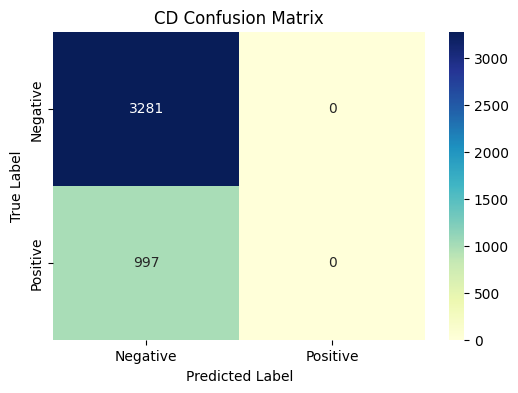

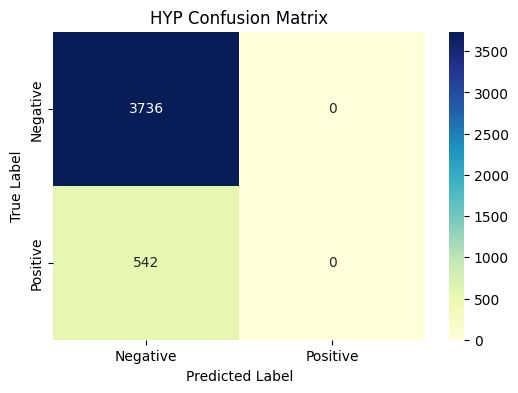

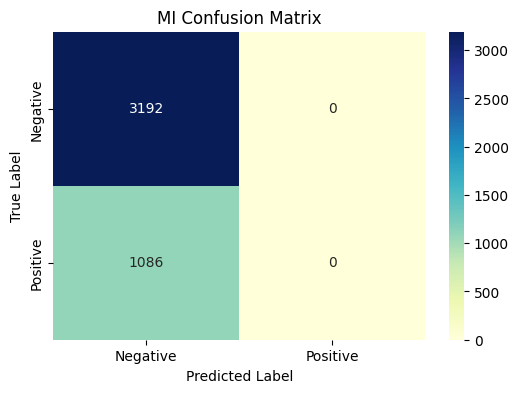

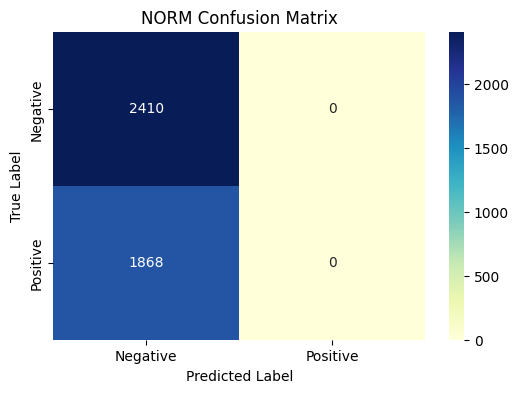

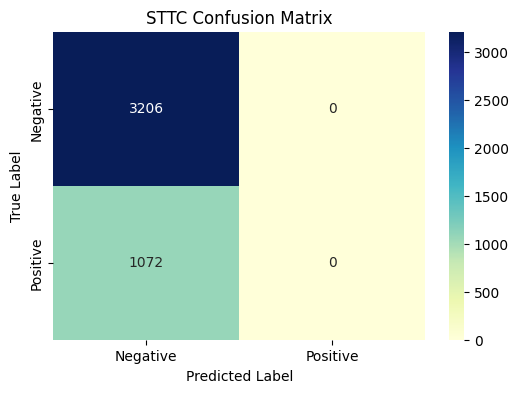

In [97]:
conf_matrix = show_confusion_matrix(y_test, y_hat, matrix_labels)